<img src=https://audiovisuales.icesi.edu.co/assets/custom/images/ICESI_logo_prin_descriptor_RGB_POSITIVO_0924.jpg width=200>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Ohtar10/icesi-nlp/blob/main/Sesion1/1-spacy-basics.ipynb)

# Maestría en Inteligencia Artificial  
## Procesamiento de Lenguaje natural
### Sesión 1 - Practica

---


**Integrantes:**  
- Johan Sebastian Bonilla  
- Edwin Gómez  

# Introducción

Este notebook utiliza [Ultralytics](https://docs.ultralytics.com/) para entrenar modelos de detección de objetos YOLO11 con un conjunto de datos personalizado. Al finalizar este Colab, tendremos un modelo YOLO entrenado específicamente para la detección de armas.

# Descripción del Dataset

El conjunto de datos utilizado en este proyecto proviene de [DaSCI (Instituto Andaluz Interuniversitario en Data Science and Computational Intelligence)](https://dasci.es/opendata/deteccion-de-armas-open-data/), específicamente de su sección “Detección de Armas – Open Data”.


**¿Qué contiene este dataset?**

DaSCI pone a disposición varios sub-conjuntos de datos orientados a la investigación en detección automática de armas a partir de imágenes, con el fin de entrenar modelos de Deep Learning para videovigilancia inteligente.


**Tiene dos grandes categorías:**



*   Clasificación de imágenes, donde las imágenes están organizadas en directorios por clase (“pistola”, “cuchillo”, etc.).


*   Detección de objetos, con anotaciones en formato Pascal VOC (XML), para que los modelos puedan aprender a localizar armas en la escena.


## Sub-conjuntos más relevantes




1.   **Detección de pistolas (Pistol Detection)**

Aproximadamente 3.000 imágenes con pistolas, en escenarios variados como videovigilancia y fondos complejos.


Todas las imágenes tienen anotaciones en formato Pascal VOC, lo que permite entrenar modelos de detección.


2.   **Detección de armas blancas (Knife Detection)**

El dataset contiene 2.078 imágenes donde aparece al menos un cuchillo.


Incluye diferentes tipos de cuchillos, distancias, oclusión y contexto, lo que lo hace robusto para tareas reales.


3.   **Sohas Weapon Detection**

Incluye seis clases de “Sohas Weapon” para la detección: pistola, cuchillo, billete, cartera, teléfono y tarjeta.


**Montar Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Importación de librerias requeridas**

In [ ]:
from __future__ import print_function, division

# ===========================
# CONFIGURACIÓN INICIAL
# ===========================

# tqdm es una librería para mostrar barras de progreso en ciclos (loops).
# "tqdm.auto" detecta si estamos en un notebook (como Kaggle o Jupyter)
# o en una terminal, y se adapta automáticamente sin mostrar advertencias.

from tqdm.auto import tqdm
tqdm.pandas()   # Integra tqdm con pandas → se ven barras de progreso en operaciones de pandas.

# ===========================
# IMPORTACIÓN DE LIBRERÍAS
# ===========================
# Estas librerías cubren diferentes tareas:
# - Numpy/Pandas: análisis de datos
# - PyTorch/Torchvision: redes neuronales
# - Albumentations: aumentación de imágenes
# - Scikit-learn: partición de datos
# - OpenCV/Skimage: procesamiento de imágenes
# - Matplotlib: visualización

!pip install ultralytics

import numpy as np
import pandas as pd
from numpy.typing import NDArray
from functools import reduce
from itertools import islice, chain
import math, copy
import matplotlib.pyplot as plt
import glob

from PIL import Image

import torch
from torch import nn, Tensor
from torch.optim import Optimizer
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchsummary import summary


import albumentations as A

from sklearn.model_selection import train_test_split
from multiprocessing import cpu_count

import zipfile
import os
import os.path as osp
from pathlib import Path
import xml.etree.ElementTree as ET
from skimage import io, transform
import seaborn as sns
import matplotlib.pyplot as plt
import typing as ty
import cv2

import shutil
import random

plt.ion()  # Activa el "modo interactivo" → las gráficas se actualizan automáticamente.

print(f"Setup completo. Usando torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.0 MB/s eta 0:00:00
Setup completo. Usando torch 2.9.0+cu126 (Tesla T4)


**Descomprime las carpetas**

In [ ]:
zip_path = "/content/drive/MyDrive/Proyecto Innovación ll/OD-WeaponDetection.zip"
extract_to = "/content/datasets"

if not os.path.exists(extract_to) or len(os.listdir(extract_to)) == 0:
    print("Descomprimiendo dataset (primera vez)...")

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        files = zip_ref.infolist()
        for f in tqdm(files, desc="Progreso", unit="archivo"):
            zip_ref.extract(f, extract_to)

    print("Completado")
else:
    print("Dataset ya existe. No se vuelve a descomprimir.")


Descomprimiendo dataset (primera vez)...


Progreso:   0%|          | 0/20181 [00:00<?, ?archivo/s]

Completado


In [ ]:
# Carpetas de origen
SOURCE_DIRS = [
    "/content/datasets/Knife_detection",
    "/content/datasets/Pistol_detection",
    "/content/datasets/Weapons and similar handled objects/Sohas_weapon-Detection"
]

# Carpetas de destino
FINAL_IMG_DIR = Path("/content/weapon_dataset/images")
FINAL_ANN_DIR = Path("/content/weapon_dataset/annotations")

FINAL_IMG_DIR.mkdir(parents=True, exist_ok=True)
FINAL_ANN_DIR.mkdir(parents=True, exist_ok=True)

# Extensiones de imágenes permitidas
base_ext = ["jpg", "jpeg", "png", "bmp", "tif", "tiff"]

# Construye automáticamente mayúsculas y minúsculas
IMG_EXT = set()
for ext in base_ext:
    IMG_EXT.add(f".{ext}")
    IMG_EXT.add(f".{ext.upper()}")


# Control para evitar duplicados
seen_files = set()

# ================================
#   RECORRER CARPETAS ORIGEN
# ================================
for base in SOURCE_DIRS:
    base_path = Path(base)

    for root, dirs, files in os.walk(base_path):
        for file in files:

            ext = Path(file).suffix
            name_no_ext = Path(file).stem

            # ¿Es imagen?
            if ext in IMG_EXT:
                if name_no_ext not in seen_files:
                    seen_files.add(name_no_ext)
                    shutil.copy(str(Path(root) / file), FINAL_IMG_DIR / file)

            # ¿Es anotación XML?
            elif ext.lower() == ".xml":
                # El XML se copia sin eliminar duplicados porque cada imagen debe tener un solo xml
                # Si hay duplicados, conservamos el primero
                xml_target = FINAL_ANN_DIR / file
                if not xml_target.exists():
                    shutil.copy(str(Path(root) / file), xml_target)

print(f"Total únicos: {len(seen_files)} imágenes")
print(f"Carpeta final de imágenes: {FINAL_IMG_DIR}")
print(f"Carpeta final de anotaciones: {FINAL_ANN_DIR}")


Total únicos: 8494 imágenes
Carpeta final de imágenes: /content/weapon_dataset/images
Carpeta final de anotaciones: /content/weapon_dataset/annotations


In [ ]:
# Extensiones válidas de imágenes
IMG_EXT = {".jpg", ".jpeg", ".png", ".bmp", ".gif", ".tiff",
           ".JPG", ".JPEG", ".PNG", ".BMP", ".GIF", ".TIFF"}

# Contar imágenes
num_imgs = sum(1 for f in FINAL_IMG_DIR.iterdir() if f.suffix in IMG_EXT)

# Contar anotaciones .xml
num_xml = sum(1 for f in FINAL_ANN_DIR.iterdir() if f.suffix.lower() == ".xml")

print(f"Total de imágenes: {num_imgs}")
print(f"Total de anotaciones (XML): {num_xml}")

Total de imágenes: 8494
Total de anotaciones (XML): 8494


**Parseo de anotaciones VOC (XML) PASCAL**

El parseo de anotaciones VOC (XML) se utiliza para leer y extraer la información de las cajas delimitadoras (bounding boxes) y las clases de los objetos anotados en formato PASCAL VOC.
Este proceso convierte esos archivos XML en un formato más usable (como CSV o TXT YOLO) para entrenar modelos de detección de objetos.

In [ ]:
def parse_voc_folder(ann_dir, img_dir):
    rows = []
    missing_count = 0

    # Lista de imágenes reales en disco
    image_files = {f.stem: f.name for f in img_dir.iterdir() if f.is_file()}

    for xml_path in sorted(ann_dir.glob('*.xml')):
        tree = ET.parse(xml_path)
        root = tree.getroot()

        # Nombre SIN extensión del xml
        xml_filename_raw = root.find('filename').text.strip()
        xml_stem = Path(xml_filename_raw).stem  # solo el nombre sin extensión

        size = root.find('size')
        W = int(size.find('width').text)
        H = int(size.find('height').text)

        # Buscar esa imagen por STEN (sin extensión)
        if xml_stem not in image_files:
            missing_count += 1
            print(f"⚠ No se encontró imagen para: {xml_stem}")
            continue

        # Usar el nombre REAL del archivo (con extensión correcta)
        real_filename = image_files[xml_stem]
        img_path = img_dir / real_filename

        for obj in root.findall('object'):
            cls = obj.find('name').text.strip().lower()
            bnd = obj.find('bndbox')
            xmin = int(float(bnd.find('xmin').text))
            ymin = int(float(bnd.find('ymin').text))
            xmax = int(float(bnd.find('xmax').text))
            ymax = int(float(bnd.find('ymax').text))

            rows.append({
                'image_path': str(img_path),
                'filename': real_filename,
                'xml_path': str(xml_path),
                'width': W, 'height': H,
                'xmin': xmin, 'ymin': ymin, 'xmax': xmax, 'ymax': ymax,
                'class': cls
            })

    print(f"[INFO] Imágenes no encontradas: {missing_count}")
    return pd.DataFrame(rows)

**Configuración de directorios y parámetros**

In [ ]:
# Ruta directa a tu dataset final
DATASET_DIR = Path("/content/weapon_dataset")
ANN_DIR = DATASET_DIR / "annotations"
IMG_DIR = DATASET_DIR / "images"

# Parseo directo del único dataset final
df = parse_voc_folder(ANN_DIR, IMG_DIR)

clases_validas = ["knife", "pistol"]
df = df[df["class"].isin(clases_validas)]

print(f"[OK] Total de registros cargados: {len(df)}")
df.head(5)


[INFO] Imágenes no encontradas: 0
[OK] Total de registros cargados: 7436


image_path           filename  \
0  /content/weapon_dataset/images/ABbframe00154.jpg  ABbframe00154.jpg   
1  /content/weapon_dataset/images/ABbframe00160.jpg  ABbframe00160.jpg   
2  /content/weapon_dataset/images/ABbframe00166.jpg  ABbframe00166.jpg   
3  /content/weapon_dataset/images/ABbframe00169.jpg  ABbframe00169.jpg   
4  /content/weapon_dataset/images/ABbframe00190.jpg  ABbframe00190.jpg   

                                            xml_path  width  height  xmin  \
0  /content/weapon_dataset/annotations/ABbframe00...   1920    1090   899   
1  /content/weapon_dataset/annotations/ABbframe00...   1920    1090   790   
2  /content/weapon_dataset/annotations/ABbframe00...   1920    1090   728   
3  /content/weapon_dataset/annotations/ABbframe00...   1920    1090   761   
4  /content/weapon_dataset/annotations/ABbframe00...   1920    1090  1165   

   ymin  xmax  ymax  class  
0   452  1010   568  knife  
1   425   883   554  knife  
2   393   830   533  knife  
3   383   855   521  knife  
4   473  1283   553  knife

Se identificó una discrepancia entre las extensiones de los archivos de imagen referenciados en los archivos XML y las presentes en el sistema de archivos. Los XML utilizan la extensión .jpg en minúsculas, mientras que las imágenes en la carpeta están nombradas con .JPG en mayúsculas, lo que ocasionó que 154 imágenes no fueran encontradas durante el proceso de carga del dataset.

#1.  Análisis exploratorio EDA


Antes de entrenar cualquier modelo de visión por computador, es fundamental realizar un análisis exploratorio del dataset. Esta etapa permite comprender mejor la distribución de clases, la variedad de escenarios presentes en las imágenes, posibles problemas en las anotaciones, así como identificar datos corruptos o desbalanceados. Un buen EDA garantiza que el modelo se entrene sobre información limpia y representativa, lo que mejora su rendimiento y evita errores posteriores.

Este bloque de código extrae información estructural de cada imagen en el dataset. A partir de la lista de rutas de imágenes, obtiene parámetros como la forma completa (alto, ancho y canales), el número de dimensiones (RGB o escala de grises), y las medidas de ancho y alto. Finalmente, organiza estos datos en un DataFrame para facilitar su análisis y validación.

In [ ]:
# ===========================
# Extraer parametros directamente de las imagenes
# ===========================

# Obtenemos la lista de nombres de archivos de las imágenes desde el DataFrame
list_image = df['image_path'].tolist()

# Inicializamos listas vacías donde guardaremos información de cada imagen
data_shape = []   # Guardará la forma completa de la imagen (alto, ancho, canales)
data_dim = []     # Guardará el número de dimensiones (ej: 2 para escala de grises, 3 para RGB)
data_w = []       # Guardará el ancho de la imagen
data_h = []       # Guardará la altura de la imagen

# Recorremos todas las imágenes con una barra de progreso (tqdm)
for path  in tqdm(list_image):  # Puede tardar unos ~40 segundos en recorrer todo

    # Leemos la imagen con skimage → obtenemos forma y número de dimensiones
    imagen = io.imread(path)
    shapes = imagen.shape      # Ejemplo: (300, 400, 3)
    dimen = imagen.ndim        # Ejemplo: 3 si es RGB, 2 si es escala de grises

    # Leemos la imagen con PIL → obtenemos ancho y alto
    imagen = Image.open(path)
    w, h = imagen.size         # size devuelve (ancho, alto)

    # Guardamos toda la información en las listas
    data_w.append(w)
    data_h.append(h)
    data_shape.append(shapes)
    data_dim.append(dimen)

# Construimos un DataFrame con toda la información recopilada
data_w_h = pd.DataFrame(
    [list_image, data_shape, data_dim, data_w, data_h]
).T.rename(columns={0:'filename', 1:'shapes', 2:'ndim', 3:'w', 4:'h'})


  0%|          | 0/7436 [00:00<?, ?it/s]

**Distribución de imagenes por Alto o Ancho**

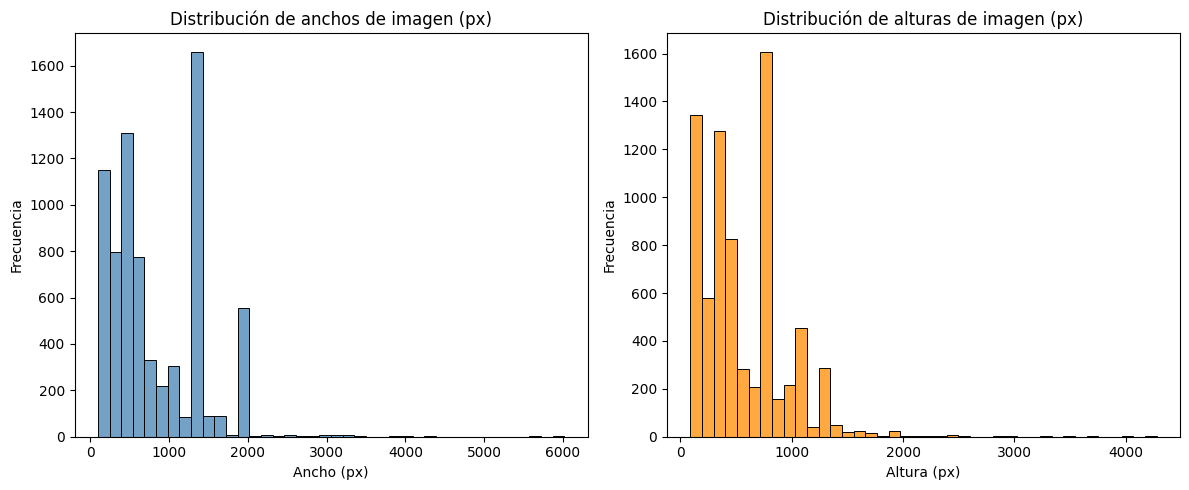

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))

sns.histplot(data_w_h['w'], bins=40, ax=ax[0], color='steelblue')
ax[0].set_title('Distribución de anchos de imagen (px)')
ax[0].set_xlabel('Ancho (px)')
ax[0].set_ylabel('Frecuencia')

sns.histplot(data_w_h['h'], bins=40, ax=ax[1], color='darkorange')
ax[1].set_title('Distribución de alturas de imagen (px)')
ax[1].set_xlabel('Altura (px)')
ax[1].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

Ancho: La mayoría de las imágenes están entre 500 y 2000 px, con picos cerca de 1000 y 1500 px. Existen pocos outliers por encima de 3000 px.

Altura: Predominan valores entre 500 y 1500 px, con un pico marcado en 1000 px. También hay casos aislados superiores a 3000 px.

Contamos cuántas imágenes tienen cada ancho (w).

In [ ]:
data_w_h['w'].value_counts()

w
1280    1487
160      940
500      790
1920     534
450      185
        ... 
739        1
597        1
219        1
810        1
605        1
Name: count, Length: 644, dtype: int64

Contamos cuántas imágenes tienen cada alto (h).

In [ ]:
data_w_h['h'].value_counts()

h
720     1462
120      940
375      328
1090     237
1080     133
        ... 
534        1
294        1
2848       1
666        1
1365       1
Name: count, Length: 756, dtype: int64

**Distribución de imagenes por Alto x Ancho**

<Axes: xlabel='w', ylabel='h'>

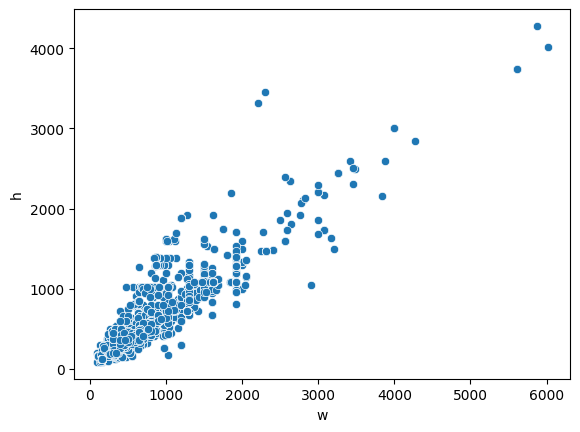

In [ ]:
data_w_h[['w', 'h']].describe()
sns.scatterplot(data=data_w_h, x='w', y='h')

**Distribución de imagenes por Canales**

In [ ]:
data_w_h['ndim'].value_counts()

ndim
3    7378
2      58
Name: count, dtype: int64

Del total de imágenes analizadas, 7.378 presentan tres canales (RGB), mientras que 58 presentan dos canales, lo que sugiere que podrían corresponder a imágenes en escala de grises.

**Distribución de imagenes por Forma**

In [ ]:
data_w_h['shapes'].value_counts()

shapes
(720, 1280, 3)     1453
(120, 160, 3)       938
(375, 500, 3)       317
(1090, 1920, 3)     237
(333, 500, 3)       112
                   ... 
(567, 634, 3)         1
(1114, 958, 3)        1
(311, 504, 3)         1
(1390, 1055, 3)       1
(606, 969)            1
Name: count, Length: 1808, dtype: int64

El tamaño más común es (720, 1280, 3) con 1.453 imágenes, seguido por (120, 160, 3) con 938. Hay combinaciones únicas, desde resoluciones muy pequeñas (120×160) hasta grandes (1920×1281).

Esta alta variabilidad en resoluciones puede afectar el entrenamiento si no se normalizan.

**Distribución de imagenes por Clase**

In [ ]:
df['class'].value_counts()

class
pistol    5042
knife     2394
Name: count, dtype: int64

Observamos un desbalance aproximado de 2 a 1 (2.1 pistolas por cada cuchillo).

Aunque no es un desbalance extremo, en el caso de detección de armas es crítico corregirlo pya que el cuchillo es visualmente más difícil de detectar que una pistola.

Pistola: Tiene una forma volumétrica clara (Forma de L), suele ser oscura y contrasta.

Cuchillo: Es delgado, metálico (refleja luz y se camufla) y dependiendo del ángulo puede verse como una simple línea recta o desaparecer.

Con este desbalance, el modelo optimizará su error ignorando los cuchillos difíciles. Vamos a nivelarlo.

**Distribución de relaciones de aspecto**

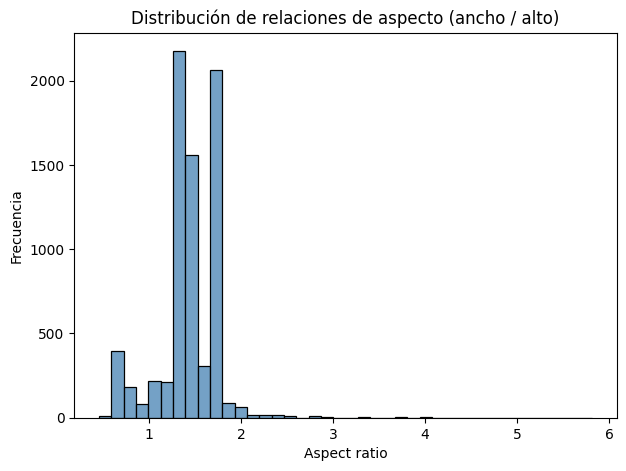

total  porcentaje (%)
Aspecto                          
Horizontal   6586           88.57
Vertical      611            8.22
Cuadrada      239            3.21

In [ ]:
data_w_h['Aspecto'] = data_w_h['w'] / data_w_h['h']

# Distribución de relaciones de aspecto
fig, ax = plt.subplots(figsize=(7,5))
sns.histplot(data_w_h['Aspecto'], bins=40, color='steelblue')
ax.set_title('Distribución de relaciones de aspecto (ancho / alto)')
ax.set_xlabel('Aspect ratio')
ax.set_ylabel('Frecuencia')
plt.show()

# Conteo por categorías de aspect ratio
def aspect_group(r):
    if r < 0.9: return "Vertical"
    elif 0.9 <= r <= 1.1: return "Cuadrada"
    else: return "Horizontal"
data_w_h['Aspecto'] = data_w_h['Aspecto'].apply(aspect_group)

aspect_counts_abs = data_w_h['Aspecto'].value_counts()
aspect_counts_pct = data_w_h['Aspecto'].value_counts(normalize=True) * 100

# Unir ambos resultados en un solo DataFrame
aspect_summary = pd.DataFrame({
    'total': aspect_counts_abs,
    'porcentaje (%)': aspect_counts_pct.round(2)
})

display(aspect_summary)


El 89% de las imágenes son horizontales, con baja proporción vertical (6.39%) y cuadrada (4.51%).

**Verificamos si existen errores en las coordenadas de las cajas delimitadoras (bounding boxes).**

In [ ]:
invalid_boxes = df[
    (df['xmin'] < 0) |
    (df['ymin'] < 0) |
    (df['xmax'] > df['width']) |
    (df['ymax'] > df['height']) |
    (df['xmax'] <= df['xmin']) |
    (df['ymax'] <= df['ymin'])
]

# Relación individual por tipo de error
relacion = (
    df[df['xmin'] >= df['xmax']].shape,
    df[df['ymin'] >= df['ymax']].shape
)

print(f"Bounding boxes inválidos encontrados: {len(invalid_boxes)}")
print(f"Relación de errores (xmin>=xmax, ymin>=ymax): {relacion}")

# --- Mostrar imágenes afectadas ---
if len(invalid_boxes) > 0:
    print("\nImágenes con errores en anotaciones:")
    print(invalid_boxes['filename'].unique())

    print("\nPrimeros bounding boxes inválidos detectados:")
    display(invalid_boxes.head())
else:
    print("No se encontraron bounding boxes inválidos.")


Bounding boxes inválidos encontrados: 1
Relación de errores (xmin>=xmax, ymin>=ymax): ((0, 10), (0, 10))

Imágenes con errores en anotaciones:
['armas (2815).jpg']

Primeros bounding boxes inválidos detectados:


image_path          filename  \
3309  /content/weapon_dataset/images/armas (2815).jpg  armas (2815).jpg   

                                               xml_path  width  height  xmin  \
3309  /content/weapon_dataset/annotations/armas (281...    259     194   730   

      ymin  xmax  ymax   class  
3309   290   758   338  pistol

Se identificó una imagen con coordenadas de bounding box inconsistentes. A continuación, se procede a su localización para análisis y corrección

In [ ]:
filenames_invalidos = invalid_boxes['filename'].unique()

# Filtrar en el DataFrame únicamente esos registros
df_filtrado = df[df['filename'].isin(filenames_invalidos)]

print("\nRegistros asociados a esos filenames:")
display(df_filtrado)



Registros asociados a esos filenames:


image_path          filename  \
3309  /content/weapon_dataset/images/armas (2815).jpg  armas (2815).jpg   
3310  /content/weapon_dataset/images/armas (2815).jpg  armas (2815).jpg   

                                               xml_path  width  height  xmin  \
3309  /content/weapon_dataset/annotations/armas (281...    259     194   730   
3310  /content/weapon_dataset/annotations/armas (281...    259     194    36   

      ymin  xmax  ymax   class  
3309   290   758   338  pistol  
3310    39   216   186  pistol

Se identificó una imagen con dos anotaciones de bounding box. Se procede a eliminar la anotación inválida para garantizar la consistencia del dataset.

In [ ]:
# Eliminar archivo de imagen
for img_path in df_filtrado["image_path"].unique():
    if os.path.exists(img_path):
        os.remove(img_path)
        print(f"Imagen eliminada: {img_path}")
    else:
        print(f"No existe la imagen: {img_path}")

# Eliminar archivo XML asociado
for xml_path in df_filtrado["xml_path"].unique():
    if os.path.exists(xml_path):
        os.remove(xml_path)
        print(f"XML eliminado: {xml_path}")
    else:
        print(f"No existe el XML: {xml_path}")

# Eliminar los registros del df.
df = df[~df["filename"].isin(df_filtrado["filename"].unique())].reset_index(drop=True)

print("\nRegistros eliminados del DataFrame:", len(df_filtrado))
print("Nuevo tamaño del DataFrame:", df.shape)


Imagen eliminada: /content/weapon_dataset/images/armas (2815).jpg
XML eliminado: /content/weapon_dataset/annotations/armas (2815).xml

Registros eliminados del DataFrame: 2
Nuevo tamaño del DataFrame: (7434, 10)


Validar que tengan la misma cantidad

In [ ]:
# Contar imágenes únicas
num_imagenes = df['image_path'].nunique()

# Contar XML únicos
num_xml = df['xml_path'].nunique()

print("Imágenes únicas:", num_imagenes)
print("XML únicos:", num_xml)

if num_imagenes == num_xml:
    print("OK: La cantidad coincide")
else:
    print("Diferencia detectada:")
    print("Imágenes únicas:", num_imagenes)
    print("XML únicos:", num_xml)


Imágenes únicas: 6741
XML únicos: 6741
OK: La cantidad coincide


Validamos nuevamente

In [ ]:
invalid_boxes = df[
    (df['xmin'] < 0) | (df['ymin'] < 0) |
    (df['xmax'] > df['width']) | (df['ymax'] > df['height']) |
    (df['xmax'] <= df['xmin']) | (df['ymax'] <= df['ymin'])
]
relacion = df[df['xmin']>=df['xmax']].shape, df[df['ymin']>=df['ymax']].shape

print(f"Bounding boxes inválidos: {len(invalid_boxes)}, Relacion:{relacion}")

Bounding boxes inválidos: 0, Relacion:((0, 10), (0, 10))


**Distribución del área de los bounding boxes**

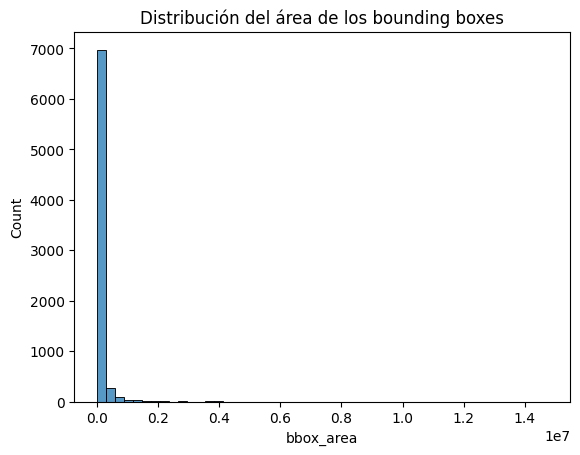

In [ ]:
df['bbox_width'] = df['xmax'] - df['xmin']
df['bbox_height'] = df['ymax'] - df['ymin']
df['bbox_area'] = df['bbox_width'] * df['bbox_height']

sns.histplot(df['bbox_area'], bins=50)
plt.title('Distribución del área de los bounding boxes')
plt.show()

**Distribución de objetos por imagen**

Text(0.5, 1.0, 'Distribución de objetos por imagen')

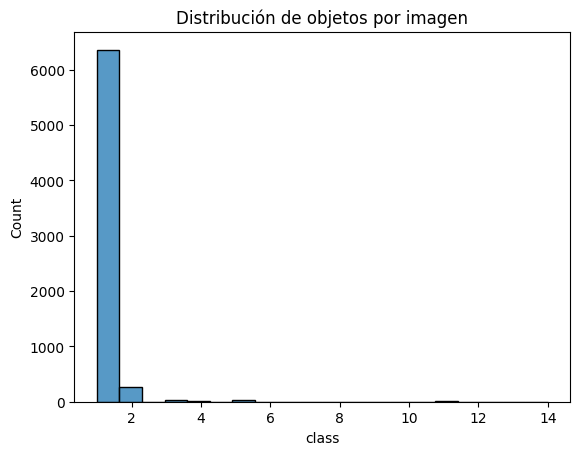

In [ ]:
obj_per_img = df.groupby('filename')['class'].count()
sns.histplot(obj_per_img, bins=20)
plt.title('Distribución de objetos por imagen')

La mayoría de las imágenes presentan un solo objeto; pocas contienen múltiples objetos (hasta 10).

**Visualización aleatoria de 5 imagenes**

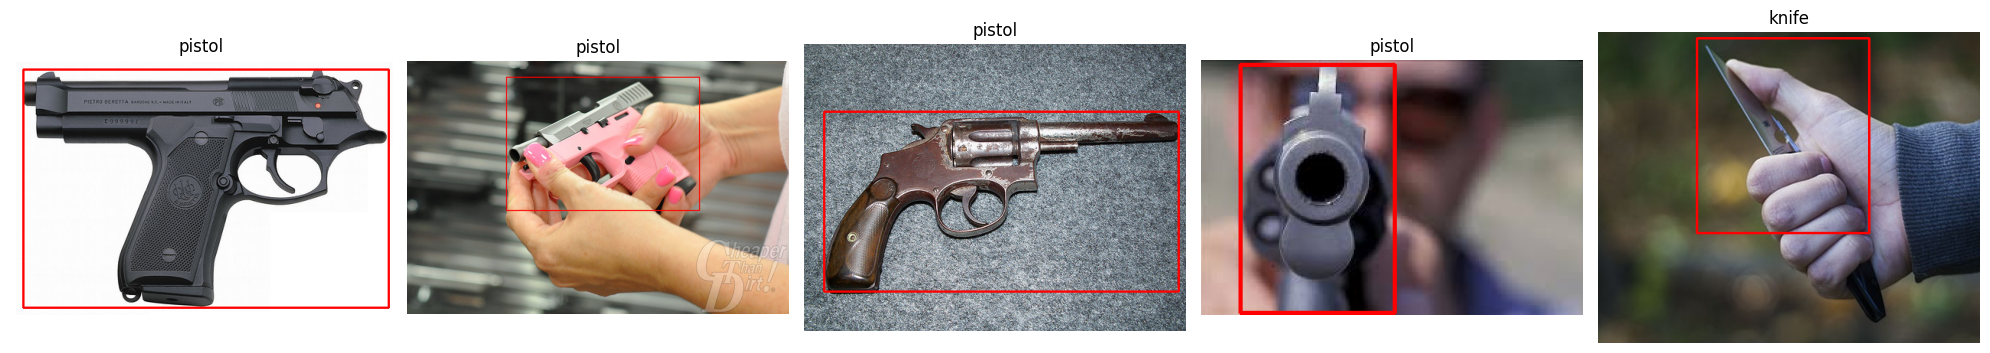

In [ ]:
sample_rows = df.sample(5)
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

for ax, (_, row) in zip(axes, sample_rows.iterrows()):
    img = cv2.imread(row['image_path'])
    if img is None:
        ax.set_title("Imagen no encontrada")
        ax.axis('off')
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.rectangle(img, (row['xmin'], row['ymin']), (row['xmax'], row['ymax']), (255, 0, 0), 2)
    ax.imshow(img)
    ax.set_title(f"{row['class']}")
    ax.axis('off')

plt.tight_layout()
plt.show()


#2.  Entrenamiendo del modelo

**Estructura necesaria para entrenar modelos YOLO (Ultralytics)**

Para entrenar un modelo YOLO (incluyendo YOLOv8–YOLO11) con Ultralytics, se requiere una estructura de directorios específica y un archivo de configuración (data.yaml).

Cada imagen debe tener un archivo .txt con el mismo nombre.

Los .txt contienen las anotaciones en formato YOLO:
class x_center y_center width height

In [ ]:
# === 1. Carpeta final para YOLO ===
YOLO_DIR = Path("yolo_dataset")
(IMGS_DIR := YOLO_DIR / "images").mkdir(parents=True, exist_ok=True)
(LABS_DIR := YOLO_DIR / "labels").mkdir(parents=True, exist_ok=True)

# === 2. Mapeo de clases a IDs ===
class_map = {cls: i for i, cls in enumerate(df["class"].str.lower().unique())}
print("Class map:", class_map)

# === 3. Convertir VOC (xmin,ymin,xmax,ymax) → YOLO (xc,yc,w,h) ===
def voc_to_yolo(row):
    xmin, ymin, xmax, ymax = row["xmin"], row["ymin"], row["xmax"], row["ymax"]
    img_w, img_h = row["width"], row["height"]

    x_center = (xmin + xmax) / 2 / img_w
    y_center = (ymin + ymax) / 2 / img_h
    w = (xmax - xmin) / img_w
    h = (ymax - ymin) / img_h

    cls_id = class_map[row["class"].lower()]

    return f"{cls_id} {x_center} {y_center} {w} {h}"

# === 4. Procesar imagen por imagen ===
for filename in df["filename"].unique():

    subset = df[df["filename"] == filename]

    # Obtener ruta de imagen (todas las filas comparten la misma)
    img_path = subset.iloc[0]["image_path"]

    # Copiar imagen
    dst_img = IMGS_DIR / filename
    if os.path.exists(img_path):
        shutil.copy(img_path, dst_img)
    else:
        print(f"⚠ No existe imagen: {img_path}")
        continue

    # Crear archivo .txt
    label_path = LABS_DIR / filename.replace(".jpg", ".txt").replace(".JPG", ".txt").replace(".jpeg", ".txt").replace(".png", ".txt")

    with open(label_path, "w") as f:
        for _, row in subset.iterrows():
            yolo_line = voc_to_yolo(row)
            f.write(yolo_line + "\n")


Class map: {'knife': 0, 'pistol': 1}


Revisar que se hallan copiado la totalidad de imagenes y labels

In [ ]:
# Contar imágenes
num_images = len([f for f in os.listdir(IMGS_DIR) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.JPG'))])

# Contar labels
num_labels = len([f for f in os.listdir(LABS_DIR) if f.lower().endswith('.txt')])

print(f"Total de imágenes: {num_images}")
print(f"Total de labels (.txt): {num_labels}")

Total de imágenes: 6741
Total de labels (.txt): 6741


**Estructura obligatoria del dataset**

```text
yolo_dataset/
├── images/
│   ├── train/
│   └── val/
└── labels/
    ├── train/
    └── val/
```

- **images/** contiene todas las imágenes.
- **labels/** contiene los archivos `.txt` con anotaciones YOLO.
- Los nombres de archivo entre *images* y *labels* deben coincidir.
- Las subdivisiones **train/** y **val/** deben tener la misma estructura.

In [ ]:
TRAIN_IMG_DIR = IMGS_DIR / "train"
VAL_IMG_DIR = IMGS_DIR / "val"
TRAIN_LAB_DIR = LABS_DIR / "train"
VAL_LAB_DIR = LABS_DIR / "val"

# Crear carpetas
TRAIN_IMG_DIR.mkdir(parents=True, exist_ok=True)
VAL_IMG_DIR.mkdir(parents=True, exist_ok=True)
TRAIN_LAB_DIR.mkdir(parents=True, exist_ok=True)
VAL_LAB_DIR.mkdir(parents=True, exist_ok=True)

# Lista de imágenes
imgs = sorted([p for p in IMGS_DIR.glob("*") if p.suffix.lower() in [".jpg",".JPG",".jpeg",".png"]])

random.shuffle(imgs)
split = int(len(imgs) * 0.8)
train_imgs = imgs[:split]
val_imgs = imgs[split:]

def move_files(img_list, target_img_dir, target_lab_dir):
    for img_path in img_list:
        label_path = LABS_DIR / (img_path.stem + ".txt")

        # mover imagen
        shutil.move(str(img_path), str(target_img_dir / img_path.name))

        # mover label (si existe)
        if label_path.exists():
            shutil.move(str(label_path), str(target_lab_dir / label_path.name))
        else:
            print(f"⚠ No tiene label: {img_path.name}")


move_files(train_imgs, TRAIN_IMG_DIR, TRAIN_LAB_DIR)
move_files(val_imgs, VAL_IMG_DIR, VAL_LAB_DIR)


Como se pudo observar en el EDA, el dataset presenta un pequeño desbalance, lo que podría ocasionar que el modelo priorice la detección de pistolas sobre cuchillos. Por esta razón, vamos a crear una copia adicional por cada imagen de la clase cuchillos para mejorar el balance.

In [ ]:
def oversample_dataset(img_folder, label_folder, target_class_id, multiplication_factor=2):
    """
    img_folder: Ruta a tus imágenes de TRAIN
    label_folder: Ruta a tus labels de TRAIN (txt)
    target_class_id: ID de la clase a aumentar (ej. 0 para Cuchillo)
    multiplication_factor: Cuántas copias extra crear por cada imagen encontrada
    """

    txt_files = glob(os.path.join(label_folder, "*.txt"))

    print(f"Procesando oversampling para la clase {target_class_id}...")

    count = 0
    for txt_file in tqdm(txt_files):
        has_target_class = False

        # 1. Verificar si el archivo contiene la clase minoritaria
        with open(txt_file, 'r') as f:
            lines = f.readlines()
            for line in lines:
                cls_id = int(line.split()[0])
                if cls_id == target_class_id:
                    has_target_class = True
                    break

        # 2. Si la tiene, duplicar imagen y label
        if has_target_class:
            base_name = os.path.splitext(os.path.basename(txt_file))[0]

            # Buscar la imagen correspondiente (jpg, png o jpeg)
            img_extensions = ['.jpg', '.jpeg', '.png']
            img_file = None
            for ext in img_extensions:
                temp_path = os.path.join(img_folder, base_name + ext)
                if os.path.exists(temp_path):
                    img_file = temp_path
                    img_ext = ext
                    break

            if img_file:
                # Crear copias
                for i in range(multiplication_factor):
                    new_name = f"{base_name}_aug_{i}"

                    # Copiar imagen
                    new_img_path = os.path.join(img_folder, new_name + img_ext)
                    shutil.copy(img_file, new_img_path)

                    # Copiar label
                    new_txt_path = os.path.join(label_folder, new_name + ".txt")
                    shutil.copy(txt_file, new_txt_path)

                    count += 1

    print(f"Se crearon {count} nuevas instancias de imágenes/labels.")

Aplicamos la función en la base de TRAIN.

In [ ]:
from glob import glob
class_id_cuchillo = 0

oversample_dataset(
    img_folder='/content/yolo_dataset/images/train',   # Solo carpeta TRAIN
    label_folder='/content/yolo_dataset/labels/train', # Solo carpeta TRAIN
    target_class_id=class_id_cuchillo,
    multiplication_factor=1  # Crear 1 copia extra por cada imagen encontrada
)

Procesando oversampling para la clase 0...


  0%|          | 0/5392 [00:00<?, ?it/s]

Se crearon 1769 nuevas instancias de imágenes/labels.


Validamos que tenemos la misma cantidad de imagenes y de labels

In [ ]:
import glob
def verificar_dataset(base_path):
    # Definimos las rutas asumiendo la estructura estándar de YOLO
    rutas = {
        "Train Images": os.path.join(base_path, 'images/train'),
        "Train Labels": os.path.join(base_path, 'labels/train'),
        "Val Images":   os.path.join(base_path, 'images/val'),
        "Val Labels":   os.path.join(base_path, 'labels/val')
    }

    conteos = {}

    print(f"{'CARPETA':<25} | {'CANTIDAD':<10} | {'TIPO'}")
    print("-" * 50)

    for nombre, ruta in rutas.items():
        if os.path.exists(ruta):
            # Para labels buscamos .txt
            if "Labels" in nombre:
                archivos = glob.glob(os.path.join(ruta, "*.txt"))
                tipo = "TXT"
            # Para imagenes buscamos extensiones comunes
            else:
                extensions = ['*.jpg','*.JPG', '*.jpeg', '*.png', '*.bmp']
                archivos = []
                for ext in extensions:
                    archivos.extend(glob.glob(os.path.join(ruta, ext)))
                tipo = "IMG"

            conteos[nombre] = len(archivos)
            print(f"{nombre:<25} | {len(archivos):<10} | {tipo}")
        else:
            conteos[nombre] = 0
            print(f"{nombre:<25} | {'NO EXISTE':<10} | ❌")

    print("-" * 50)

    # --- VERIFICACIÓN DE PARES ---
    diff_train = conteos["Train Images"] - conteos["Train Labels"]
    diff_val = conteos["Val Images"] - conteos["Val Labels"]

    if diff_train == 0:
        print("TRAIN: Correcto. Cada imagen tiene su label.")
    else:
        print(f"TRAIN: ¡ALERTA! Hay una diferencia de {diff_train} archivos.")
        if diff_train > 0:
            print("Mas imagenes que labels.")
        else:
            print("Mas labels que imágenes.")

    if diff_val == 0:
        print("Cada imagen tiene su label.")
    else:
        print(f"Hay una diferencia de {diff_val} archivos.")

# EJECUTAR VERIFICACIÓN
# Asegúrate de que esta sea la ruta base donde están las carpetas 'images' y 'labels'
ruta_base = '/content/yolo_dataset'

verificar_dataset(ruta_base)

CARPETA                   | CANTIDAD   | TIPO
--------------------------------------------------
Train Images              | 7161       | IMG
Train Labels              | 7161       | TXT
Val Images                | 1349       | IMG
Val Labels                | 1349       | TXT
--------------------------------------------------
TRAIN: Correcto. Cada imagen tiene su label.
Cada imagen tiene su label.


**Archivo data.yaml**

In [ ]:
YOLO_DIR = "/content/yolo_dataset"

yaml_text = f"""
path: {YOLO_DIR}

train: images/train
val: images/val

names:
  0: knife
  1: pistol
"""

with open("weapons.yaml", "w") as f:
    f.write(yaml_text)

**Entrenamiento del modelo YOLO**

In [ ]:
from ultralytics import YOLO

model = YOLO("yolo11s.pt")

model.train(
    data="weapons.yaml",
    epochs=20, # YOLO11 converge rápido, pero necesitamos suficientes épocas para refinar la detección de objetos pequeños, sin embargo por limitacion de recurso lo dejamos en 25.
    imgsz=640, # Resolución de las imagenes
    batch=16,  # Pro limitacion en recurso dejo 16
    project="weapons_training",
    name="yolo11_weapons",
    device=0,
    workers=2,        # Colab suele ir bien con 2
    patience=10,      # Early stopping

    # --- HIPERPARÁMETROS DE AUMENTACIÓN ---

    # 1. Geometría (Ángulos difíciles en asaltos)
    mosaic=1.0,         # SIEMPRE activado. Mezcla 4 imágenes. Vital para contexto.
    degrees=15.0,       # Rota la imagen +/- 15°. Las armas nunca están perfectamente rectas en un robo.
    shear=2.5,          # Deforma la perspectiva. Simula mirar desde una cámara en el techo.
    scale=0.5,          # Escala la imagen +/- 50%. Ayuda a detectar armas lejos y cerca.
    fliplr=0.5,         # Espejo horizontal (50% prob). Una pistola se ve igual apuntando a izq o der.

    # 2. Iluminación y Color (Cámaras nocturnas o mala luz)
    hsv_h=0.015,        # Variación pequeña de tono.
    hsv_s=0.7,          # Variación ALTA de saturación. Algunas cámaras saturan mucho o son blanco y negro.
    hsv_v=0.4,          # Variación ALTA de brillo (Valor). Simula luz de día vs. callejón oscuro.

    # # 3. Calidad de Imagen (Lo que diferencia una foto HD de un frame de video)
    # # Nota: Estos valores no vienen por defecto en 0, hay que activarlos para tu caso.
    # blur=0.1,           # (Probabilidad) Aplica desenfoque. Los videos de asaltos suelen estar movidos.
    erasing=0.4,        # (Probabilidad) "Borra" parches aleatorios. Simula oclusiones (mano tapando parte del arma).
    # noise=0.1,          # Añade ruido granulado. Típico en sensores de cámaras con poca luz (ISO alto).

    # 4. Optimización
    optimizer='AdamW',  # Generalmente converge mejor y más estable que SGD para datasets medianos.
    lr0=0.001,          # Learning rate inicial (valor estándar seguro).
    cos_lr=True,        # Decae el learning rate suavemente, ayuda a afinar al final.

    exist_ok=True   # NO crea exp2, usa weapons_training/exp siempre
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.231 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=weapons.yaml, degrees=15.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d00aa40b380>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

**Guardamos el mejor modelo**

In [ ]:
# Cargar tu modelo entrenado
best_model = YOLO("/content/weapons_training/yolo11_weapons/weights/best.pt")

# Validación sobre el conjunto de validación
metrics = best_model.val(project="runs", exist_ok=True)

Ultralytics 8.3.231 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,413,574 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1722.2±452.9 MB/s, size: 117.1 KB)
val: Scanning /content/yolo_dataset/labels/val.cache... 1349 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1349/1349 1.8Mit/s 0.0s
val: /content/yolo_dataset/images/val/armas (2843).jpg: corrupt JPEG restored and saved
val: /content/yolo_dataset/images/val/armas (583).jpg: corrupt JPEG restored and saved
val: /content/yolo_dataset/images/val/knife_71.jpg: corrupt JPEG restored and saved
val: /content/yolo_dataset/images/val/pistol_1717.jpg: corrupt JPEG restored and saved
val: /content/yolo_dataset/images/val/pistol_2140.jpg: corrupt JPEG restored and saved
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 85/85 4.5it/s 18.8s
                   all       1349       1497      

Revisamos metricas de desempeño

In [ ]:
print("Métricas YOLO:")
print("mAP50:", metrics.box.map50)
print("mAP50-95:", metrics.box.map)
print("Precision:", metrics.box.mp)
print("Recall:", metrics.box.mr)

Métricas YOLO:
mAP50: 0.9482340971549891
mAP50-95: 0.6949126508660701
Precision: 0.9243531918365493
Recall: 0.8955731095171559


Graficamos el desempeño del modelo

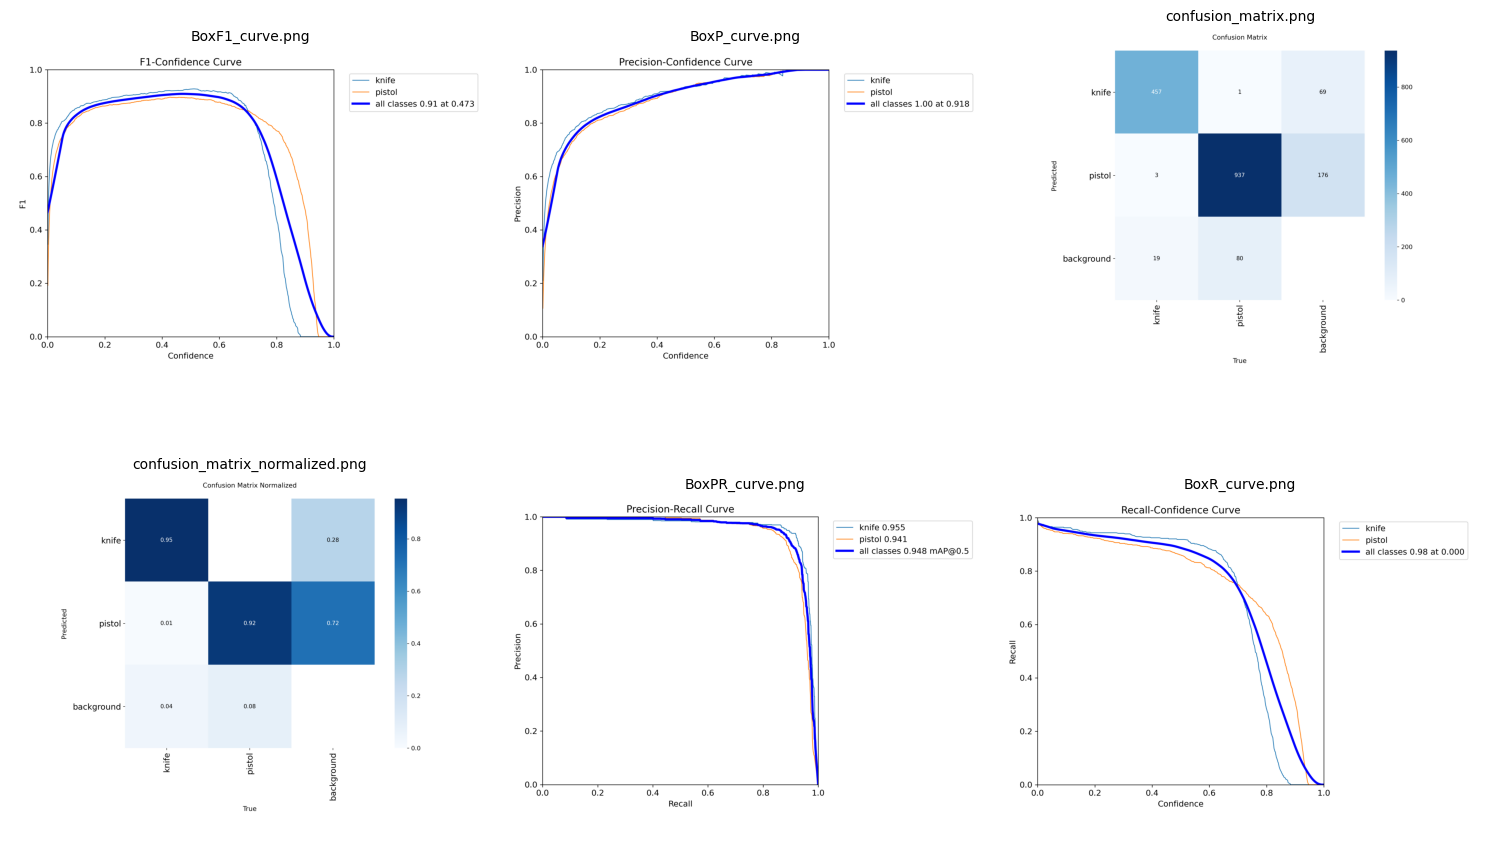

In [ ]:
# Ruta donde YOLO guarda resultados
val_path = "/content/runs/val"  # Ajusta según tu carpeta (exp, exp2, etc.)

# Obtener todas las imágenes PNG
images = glob.glob(val_path + "/*.png")

# Configurar la cuadrícula
cols = 3  # Número de columnas
rows = (len(images) + cols - 1) // cols  # Calcular filas necesarias

plt.figure(figsize=(15, 5 * rows))

for i, img_path in enumerate(images):
    img = Image.open(img_path)
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(img_path.split("/")[-1], fontsize=10)

plt.tight_layout()
plt.show()

**Hacemos predicciones en algunas imagenes del dataset de VAL**

In [ ]:
VAL_IMG_DIR = Path("/content/yolo_dataset/images/val")

val_paths = [str(VAL_IMG_DIR / f) for f in os.listdir(VAL_IMG_DIR)
             if f.lower().endswith((".jpg",".JPG", ".jpeg", ".png"))]


image 1/1 /content/yolo_dataset/images/val/LBmframe00265.jpg: 384x640 1 knife, 88.6ms
Speed: 3.2ms preprocess, 88.6ms inference, 6.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/yolo_dataset/images/val/KravMagaTraining705.jpg: 384x640 1 knife, 15.9ms
Speed: 2.3ms preprocess, 15.9ms inference, 3.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/yolo_dataset/images/val/armas (495).jpg: 544x640 1 pistol, 82.8ms
Speed: 4.3ms preprocess, 82.8ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolo_dataset/images/val/knife_1191.jpg: 384x640 1 knife, 11.8ms
Speed: 2.2ms preprocess, 11.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/yolo_dataset/images/val/pistol_5087.jpg: 384x640 1 pistol, 11.9ms
Speed: 3.1ms preprocess, 11.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/yolo_dataset/images/val/DefenseKnifeAttack0762.jpg: 384x640

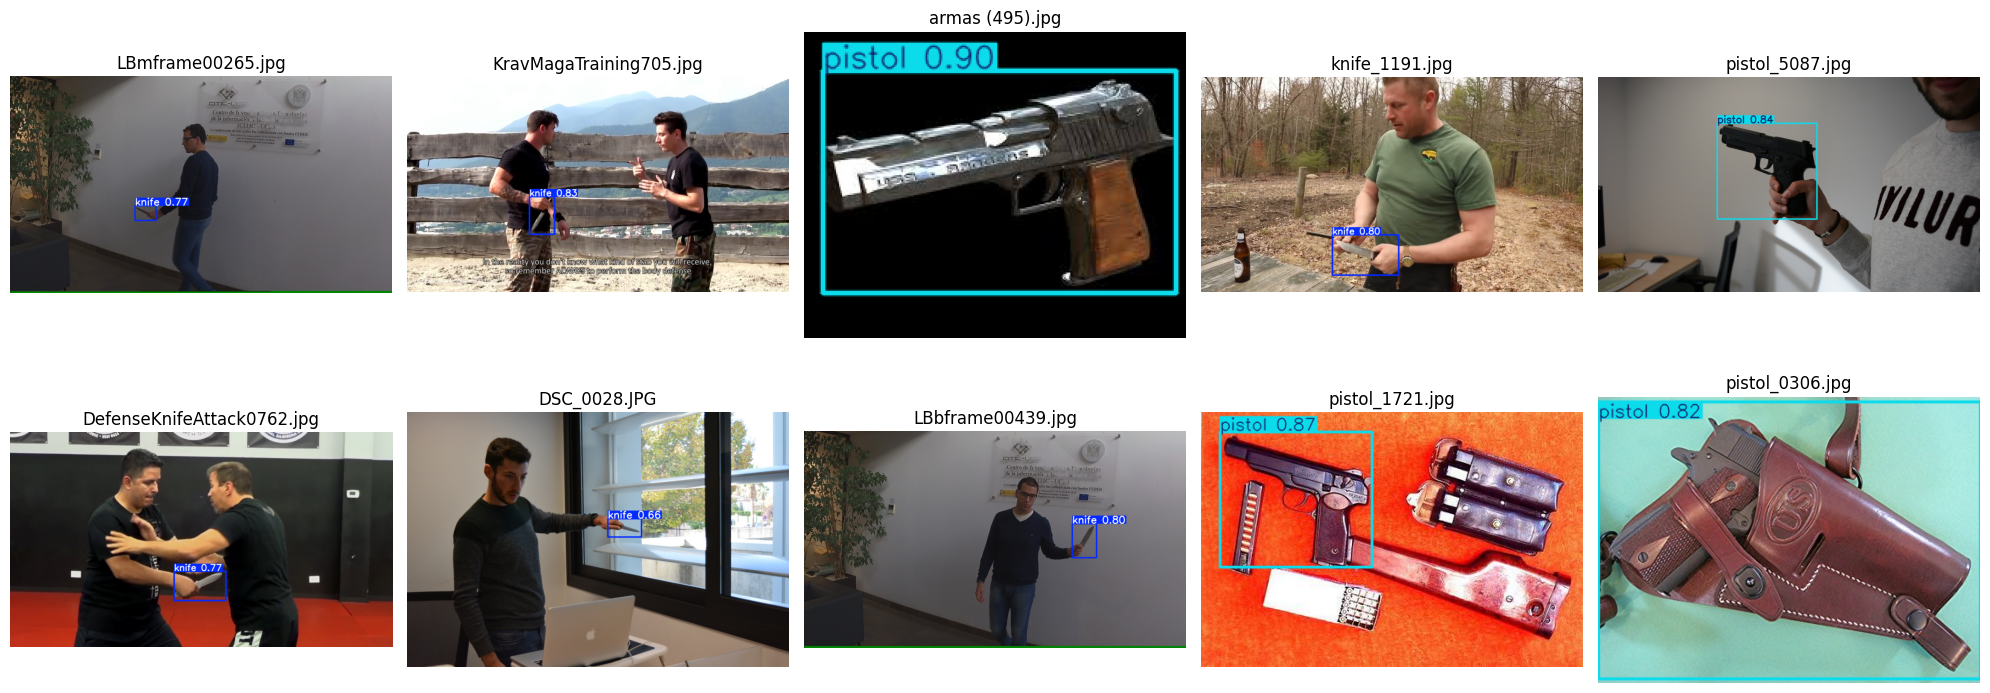

In [ ]:
# Mostrar 10 imágenes de validación
N = 10
images_to_show = val_paths[:N]

# Crear grilla 2x5
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

for ax, img_path in zip(axs.flatten(), images_to_show):

    results = best_model(img_path, conf=0.5)       # predicción
    pred_img = results[0].plot()    # imagen con boxes

    pred_img = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)

    ax.imshow(pred_img)
    ax.set_title(img_path.split("/")[-1])
    ax.axis("off")

plt.tight_layout()
plt.show()


**Validamos con algunas imagenes en contexto real, donde los angulos y la luz pueden afectar la predicción**

Total imágenes encontradas: 10

image 1/1 /content/datasets/Valid/Valid_05.jpg: 384x640 3 pistols, 11.4ms
Speed: 2.2ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/datasets/Valid/Valid_10.jpg: 384x640 1 knife, 10.6ms
Speed: 2.2ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/datasets/Valid/Valid_04.jpg: 448x640 1 knife, 12.5ms
Speed: 2.0ms preprocess, 12.5ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/datasets/Valid/Valid_06.jpg: 448x640 (no detections), 11.8ms
Speed: 1.9ms preprocess, 11.8ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/datasets/Valid/Valid_01.jpg: 640x448 (no detections), 53.3ms
Speed: 2.0ms preprocess, 53.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 /content/datasets/Valid/Valid_09.jpg: 416x640 (no detections), 56.2ms
Speed: 2.1ms preproc

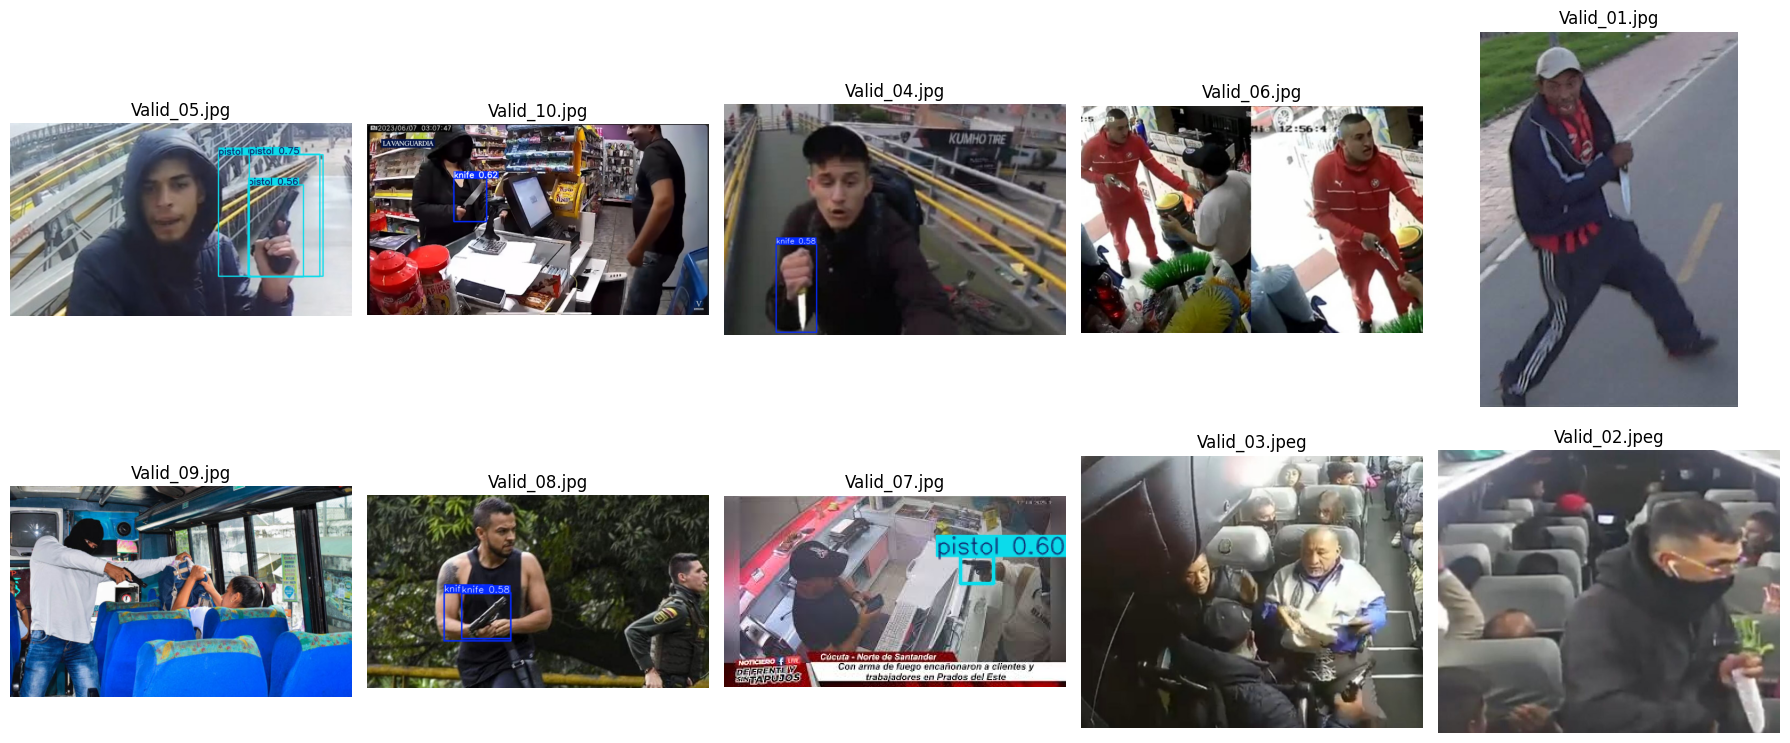

In [ ]:

# Ruta de imágenes
val_dir = "/content/datasets/Valid"

# Extensiones permitidas
exts = ["*.jpg", "*.jpeg", "*.png", "*.JPG", "*.JPEG", "*.PNG"]

# Obtener lista de imágenes
val_paths = []
for e in exts:
    val_paths.extend(glob.glob(f"{val_dir}/{e}"))

print(f"Total imágenes encontradas: {len(val_paths)}")

# Mostrar primeras N imágenes
N = 10
images_to_show = val_paths[:N]

# Crear figura (2 filas x 5 columnas → ajustable)
fig, axs = plt.subplots(2, 5, figsize=(18, 8))

for ax, img_path in zip(axs.flatten(), images_to_show):

    # Predicción con YOLO
    results = best_model(img_path, conf=0.5)

    # Imagen con boxes
    pred_img = results[0].plot()

    # BGR → RGB
    pred_img = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)

    # Plot
    ax.imshow(pred_img)
    ax.set_title(img_path.split("/")[-1])
    ax.axis("off")

# Ajustar gráficos
plt.tight_layout()
plt.show()


**Referencias:**

**Documentación oficial Ultralytics**

🔗 Dataset structure (Ultralytics Docs):
https://docs.ultralytics.com/datasets/detect/

🔗 Training guide:
https://docs.ultralytics.com/modes/train/

🔗 YOLO11:
https://docs.ultralytics.com/es/models/yolo11/

@software{yolo11_ultralytics,
  author = {Glenn Jocher and Jing Qiu},
  title = {Ultralytics YOLO11},
  version = {11.0.0},
  year = {2024},
  url = {https://github.com/ultralytics/ultralytics},
  orcid = {0000-0001-5950-6979, 0000-0003-3783-7069},
  license = {AGPL-3.0}
}